In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

In [44]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.block(x) + x


In [45]:
class ResNet(nn.Module):
    def __init__(self, in_channels, hidden_channels=32, out_channels=3, num_blocks=9):
        super(ResNet, self).__init__()

        self.input_block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(),
        )

        self.residual_blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.residual_blocks.append(ResidualBlock(hidden_channels, hidden_channels, hidden_channels))

        self.output_block = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.input_block(x)
        for block in self.residual_blocks:
            x = block(x)
        x = self.output_block(x)
        return x


In [46]:
def show_images(images):
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

In [47]:
def show_minibatch_images(images):
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        image = image[0].detach().cpu().numpy()
        image = image.transpose(1, 2, 0)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

In [48]:
def get_pyramid(image, n_layers):
    image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    image = image.unsqueeze(0)
    pyramid = [image]
    for _ in range(n_layers - 1):
        image = F.max_pool2d(image, kernel_size=2)
        pyramid.append(image)
    show_minibatch_images(pyramid)
    return pyramid

In [51]:
def show_output(output):
    output = output[0].detach().cpu().numpy()
    output = output.transpose(1, 2, 0)
    plt.imshow(output)
    plt.axis('off')
    plt.show()

In [52]:
def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using:', device)

using: cuda


In [ ]:
n_layers = 3
lr = [0.02, 0.01, 0.005]
epochs = [200, 200, 200]

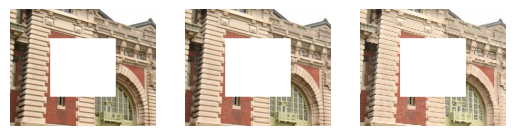

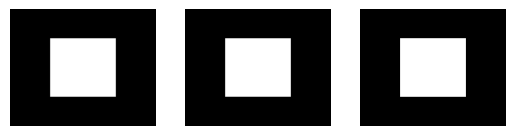

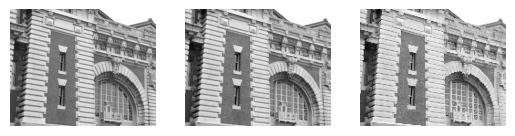

In [56]:

color_path = './color/img2.png'
mask_path = './mask/img2.png'
gray_path = './gray/img2.png'

color = cv2.cvtColor(cv2.imread(color_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path)
gray = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)[:,:,np.newaxis]

color_pyramid = get_pyramid(color, n_layers)[::-1]
mask_pyramid = get_pyramid(mask, n_layers)[::-1]
gray_pyramid = get_pyramid(gray, n_layers)[::-1]

Layer 0:  16%|█▌        | 32/201 [00:00<00:02, 77.31it/s]

Layer 0: 100%|██████████| 201/201 [00:02<00:00, 78.52it/s]


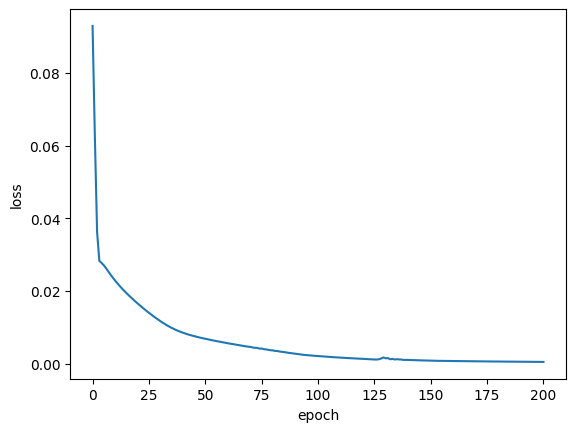

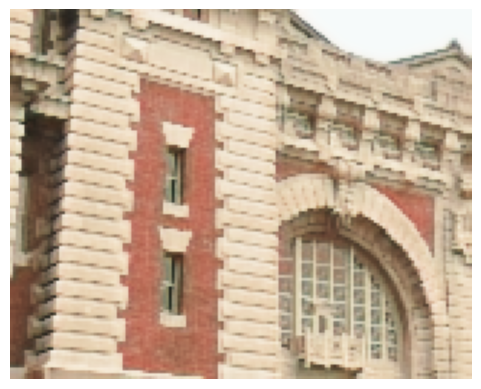

Layer 1: 100%|██████████| 201/201 [00:09<00:00, 20.35it/s]


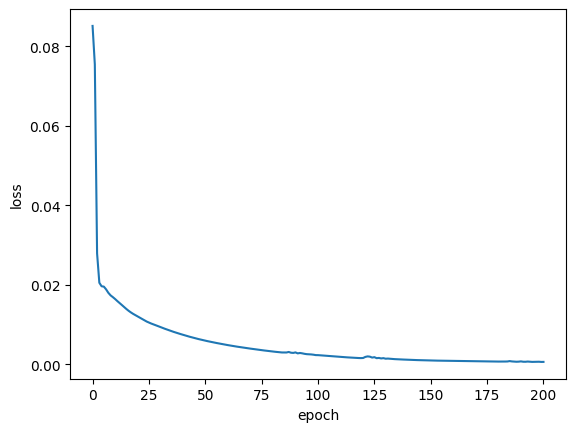

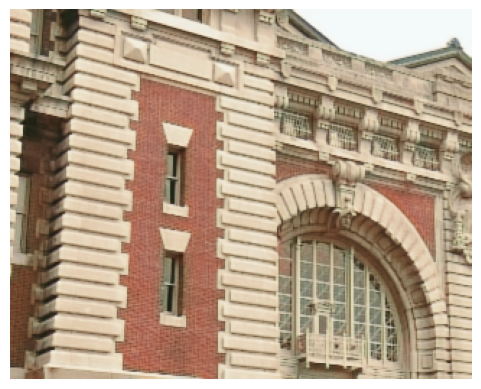

Layer 2: 100%|██████████| 201/201 [00:39<00:00,  5.07it/s]


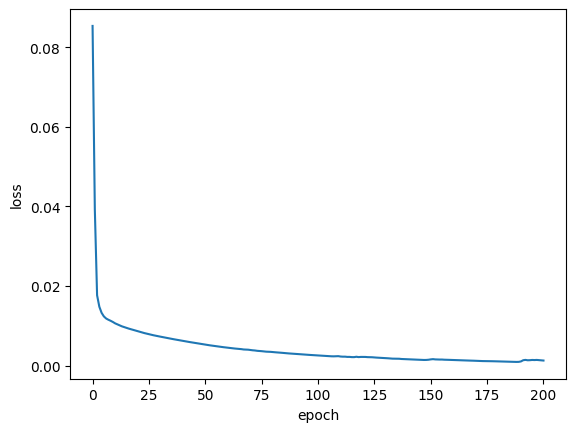

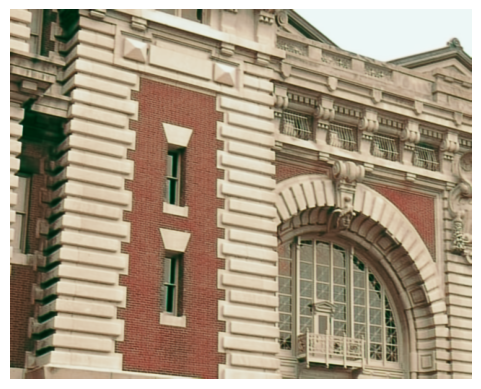

In [53]:
results = []
criterion = nn.MSELoss()
for i, (color, mask, gray) in enumerate(zip(color_pyramid, mask_pyramid, gray_pyramid)):
    color = color.to(device)
    gray = gray.to(device)
    mask = 1.0 - mask.to(device)

    if i == 0:
        input = gray
    else:
        output = output.squeeze().detach()
        output = transforms.Resize((gray.shape[2], gray.shape[3]))(output)
        output = output.unsqueeze(0)
        output = torch.clamp(output, min=0, max=1)
        input = torch.cat((gray, output), dim=1)

    target = color * mask

    model = ResNet(in_channels=input.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr[i])
    losses = []
    steps = []
    for epoch in tqdm(range(epochs[i] + 1), desc=f'Layer {i}'):
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output * mask, target)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

    plot_losses(losses)
    show_minibatch_images([output])


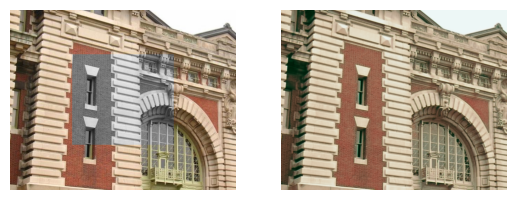

In [54]:
input = color_pyramid[-1] * (1.0 - mask_pyramid[-1]) + gray_pyramid[-1] * mask_pyramid[-1]
show_minibatch_images([input, output])